In [19]:
import numpy as np
#if this fails, you need to put the case_studies.py file in the same folder
from case_studies import *

In [20]:
from scipy.optimize import minimize

#These are the example optimizers you should evaluate this week.
#These ar eoptimizers implemented in scipy.
#they take as first 2 or 3 arguments the function f, its gradient df and sometimes its hessian Hf.
#the next parameters are all the same: x0 is the starting point, max_iterations the stopping criterion for iterations
#and epsilon the precision tolerance to be reached. 
#Note: epsilon is interpreted slightly differently across algorithms, and some algorithms might not reach the tolerance
#and stop early.
def scipy_bfgs(f,df,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="BFGS", jac=df, tol=epsilon,options={'maxiter':max_iterations, 'gtol':epsilon})
    return np.array(xs), np.array(grad_norms)

def scipy_newton(f,df,Hf,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="Newton-CG", jac=df, hess=Hf, tol=epsilon,options={'maxiter':max_iterations,'xtol':epsilon})
    return np.array(xs), np.array(grad_norms)

def scipy_trust_region(f,df,Hf,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="trust-exact", jac=df, hess=Hf, tol=epsilon,options={'maxiter':max_iterations})
    return np.array(xs), np.array(grad_norms)

In [21]:
#example usage of the algorithms
#the output is a list of points evaluated on the function as well as the gradient norms at that point
#this algorithms has the first three arguments functions for function value, gradient and Hessian.
#For the 5 functions, those are named f1-f5 etc and cna be found in the case_studies.py file
x0=np.ones(2)
xs,grad_norms = scipy_trust_region(f4,df4,Hf4,x0, 1000, 1.e-10)


#the optimal point for a given function and dimensionality is stored in the package as well for at least 15 decimals precision
optimal = x_opt("f4", 2)
print("final solution point:", xs[-1])
print("distance of x from optimum", np.linalg.norm(xs[-1]-optimal))
print("number of function evaluations:", len(grad_norms))
print("final function value:", f4(xs[-1]))
print("final gradient norm:", grad_norms[-1])


final solution point: [0.00190933 0.00190933]
distance of x from optimum 1.1857524696459338e-11
number of function evaluations: 9
final function value: 1.2203194789920598e-05
final gradient norm: 9.977761920841575e-11


# Testing Protocol for Optimization Algorithm Comparison

We implement a comprehensive testing protocol to compare the three optimization algorithms (BFGS, Newton-CG, Trust Region) on functions f1-f5.

## Methodology:
- Sample 100 initial points from multivariate Gaussian N(x*, 100·I) centered at each function's optimum
- Run each optimizer with tolerance ε=1e-6 and max 1000 iterations
- Track f(x_j) - f(x*) and |x_j - x*| at each iteration
- Aggregate statistics across all runs: median, 75th percentile, and 99th percentile
- Visualize median convergence (solid line), shaded area from median to 75th percentile, and 99th percentile (dashed)
- Show epsilon threshold (dotted line) to indicate stopping criterion

In [22]:
import matplotlib.pyplot as plt
import time
from collections import defaultdict

def generate_initial_points(x_optimal, n_points=100, variance=100, seed=42):
    """Generate initial points from N(x*, variance·I)"""
    np.random.seed(seed)
    dim = len(x_optimal)
    cov = variance * np.eye(dim)
    return np.random.multivariate_normal(x_optimal, cov, size=n_points)

def run_optimizer_with_tracking(optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon):
    """Run optimizer and track convergence metrics"""
    start_time = time.time()
    
    if optimizer == scipy_bfgs:
        xs, grad_norms = optimizer(f, df, x0, max_iter, epsilon)
    else:
        xs, grad_norms = optimizer(f, df, Hf, x0, max_iter, epsilon)
    
    elapsed_time = time.time() - start_time
    
    f_errors = np.array([f(x) - f_opt_val for x in xs])
    x_errors = np.array([np.linalg.norm(x - x_opt_val) for x in xs])
    
    return {
        'iterations': len(xs),
        'time': elapsed_time,
        'f_errors': f_errors,
        'x_errors': x_errors,
        'grad_norms': grad_norms
    }

def run_testing_protocol(function_suite, optimizers, n_initial_points=100, max_iter=1000, epsilon=1e-6):
    """Run complete testing protocol"""
    results = defaultdict(lambda: defaultdict(list))
    
    for func_name, f, df, Hf, dim in function_suite:
        x_opt_val = x_opt(func_name, dim)
        f_opt_val = f(x_opt_val)
        initial_points = generate_initial_points(x_opt_val, n_initial_points)
        
        for opt_name, optimizer in optimizers:
            for x0 in initial_points:
                try:
                    result = run_optimizer_with_tracking(
                        optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon
                    )
                    results[func_name][opt_name].append(result)
                except:
                    continue
    
    return results

def aggregate_run_statistics(run_results):
    """Aggregate runs to compute median, 75th percentile and 99th percentile.
    
    Returns a dict containing step-aligned and time-aligned statistics:
      - 'steps': integer step indices
      - 'median_steps', 'p75_steps', 'p99_steps': arrays over steps
      - 'time': time grid (same length as steps)
      - 'median_time', 'p75_time', 'p99_time': arrays over time grid
    
    Behavior for runs with different lengths: we pad each run's error array by
    repeating its final value so all runs align to the same length (max length).
    Time-alignment is done by interpolating each run's errors onto a common time
    grid (linspace from 0 to max runtime across runs) with the same number of
    points as the step grid.
    """
    # Collect absolute errors for each run and ensure non-zero floor
    error_lists = [np.abs(r['f_errors']) + 1e-20 for r in run_results]
    lengths = [len(e) for e in error_lists]
    max_len = max(lengths)
    
    # Pad shorter runs by repeating their final value (edge padding)
    padded = np.array([
        np.pad(e, (0, max_len - len(e)), mode='edge') if len(e) < max_len else e
        for e in error_lists
    ])
    
    # Step-wise statistics
    median_steps = np.percentile(padded, 50, axis=0)
    p75_steps = np.percentile(padded, 75, axis=0)
    p99_steps = np.percentile(padded, 99, axis=0)
    steps = np.arange(max_len)
    
    # Time grid: use same number of points as steps and span 0..max_time
    max_time = max(r['time'] for r in run_results)
    n_time_points = max_len
    time_grid = np.linspace(0, max_time, n_time_points)
    
    # Interpolate each run's (time, errors) onto time_grid
    interp_errors = []
    for r, e in zip(run_results, error_lists):
        times = np.linspace(0, r['time'], len(e))
        interp = np.interp(time_grid, times, e)
        interp_errors.append(interp)
    
    interp_arr = np.array(interp_errors)
    median_time = np.percentile(interp_arr, 50, axis=0)
    p75_time = np.percentile(interp_arr, 75, axis=0)
    p99_time = np.percentile(interp_arr, 99, axis=0)
    
    return {
        'steps': steps,
        'median_steps': median_steps,
        'p75_steps': p75_steps,
        'p99_steps': p99_steps,
        'time': time_grid,
        'median_time': median_time,
        'p75_time': p75_time,
        'p99_time': p99_time
    }

In [23]:
def plot_convergence_comparison(results, function_suite, epsilon=1e-8):
    """Create convergence plots: steps (left) and time (right) for each function
    
    Plots median (solid line), shaded area between median and 75th percentile,
    and 99th percentile (dashed line) for each optimizer across all runs.
    Also shows epsilon threshold as horizontal line.
    """
    n_funcs = len(function_suite)
    fig, axes = plt.subplots(n_funcs, 2, figsize=(14, 3.5*n_funcs))
    if n_funcs == 1:
        axes = axes.reshape(1, -1)
    
    opt_colors = {'BFGS': 'red', 'Newton-CG': 'green', 'Trust-Region': 'blue'}
    
    for idx, (func_name, _, _, _, _) in enumerate(function_suite):
        ax_steps = axes[idx, 0]
        ax_time = axes[idx, 1]
        
        for opt_name in ['BFGS', 'Newton-CG', 'Trust-Region']:
            run_results = results[func_name][opt_name]
            if not run_results:
                continue
            
            color = opt_colors[opt_name]
            stats = aggregate_run_statistics(run_results)
            
            # Plot steps: median, shaded area to 75th percentile, and 99th percentile
            ax_steps.semilogy(stats['steps'], stats['median_steps'], 
                             color=color, linewidth=2, label=f'{opt_name} median')
            ax_steps.fill_between(stats['steps'], 
                                 stats['median_steps'],
                                 stats['p75_steps'],
                                 color=color, alpha=0.3)
            ax_steps.semilogy(stats['steps'], stats['p99_steps'], 
                             color=color, linewidth=1.5, linestyle='--', alpha=0.7)
            
            # Plot time: median, shaded area to 75th percentile, and 99th percentile
            ax_time.semilogy(stats['time'], stats['median_time'], 
                            color=color, linewidth=2, label=f'{opt_name} median')
            ax_time.fill_between(stats['time'], 
                                stats['median_time'],
                                stats['p75_time'],
                                color=color, alpha=0.3)
            ax_time.semilogy(stats['time'], stats['p99_time'], 
                            color=color, linewidth=1.5, linestyle='--', alpha=0.7)
        
        # Add epsilon threshold line
        ax_steps.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5, label=f'ε={epsilon}')
        ax_time.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5, label=f'ε={epsilon}')
        
        # Set y-axis limits starting from epsilon
        ax_steps.set_ylim(bottom=epsilon)
        ax_time.set_ylim(bottom=epsilon)
        
        # Format plots
        ax_steps.set_xlabel('steps', fontsize=10)
        ax_steps.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
        ax_steps.set_title(f'steps to reach tolerance on {func_name}', fontsize=11)
        ax_steps.grid(True, alpha=0.3, linewidth=0.5)
        
        ax_time.set_xlabel('time (s)', fontsize=10)
        ax_time.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
        ax_time.set_title(f'time to reach tolerance on {func_name}', fontsize=11)
        ax_time.grid(True, alpha=0.3, linewidth=0.5)
        
        # Legend on right plots only
        legend_elements = [
            plt.Line2D([0], [0], color='red', linewidth=2, label='BFGS'),
            plt.Line2D([0], [0], color='green', linewidth=2, label='Newton-CG'),
            plt.Line2D([0], [0], color='blue', linewidth=2, label='Trust-Region'),
            plt.Line2D([0], [0], color='gray', linewidth=2, label='median'),
            plt.Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='99th percentile'),
            plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, label='median to 75th percentile'),
            plt.Line2D([0], [0], color='black', linestyle=':', linewidth=1.5, label=f'ε={epsilon}')
        ]
        ax_time.legend(handles=legend_elements, loc='best', fontsize=9, framealpha=0.9)
    
    plt.tight_layout()
    return fig

In [24]:
# Define test suite and run protocol
function_suite = [
    ("f1", f1, df1, Hf1, 2),
    ("f2", f2, df2, Hf2, 2),
    ("f3", f3, df3, Hf3, 2),
    ("f4", f4, df4, Hf4, 2),
    ("f5", f5, df5, Hf5, 2)
]

optimizers = [
    ("BFGS", scipy_bfgs),
    ("Newton-CG", scipy_newton),
    ("Trust-Region", scipy_trust_region)
]

results = run_testing_protocol(function_suite, optimizers, n_initial_points=50, 
                               max_iter=1000, epsilon=1e-8)

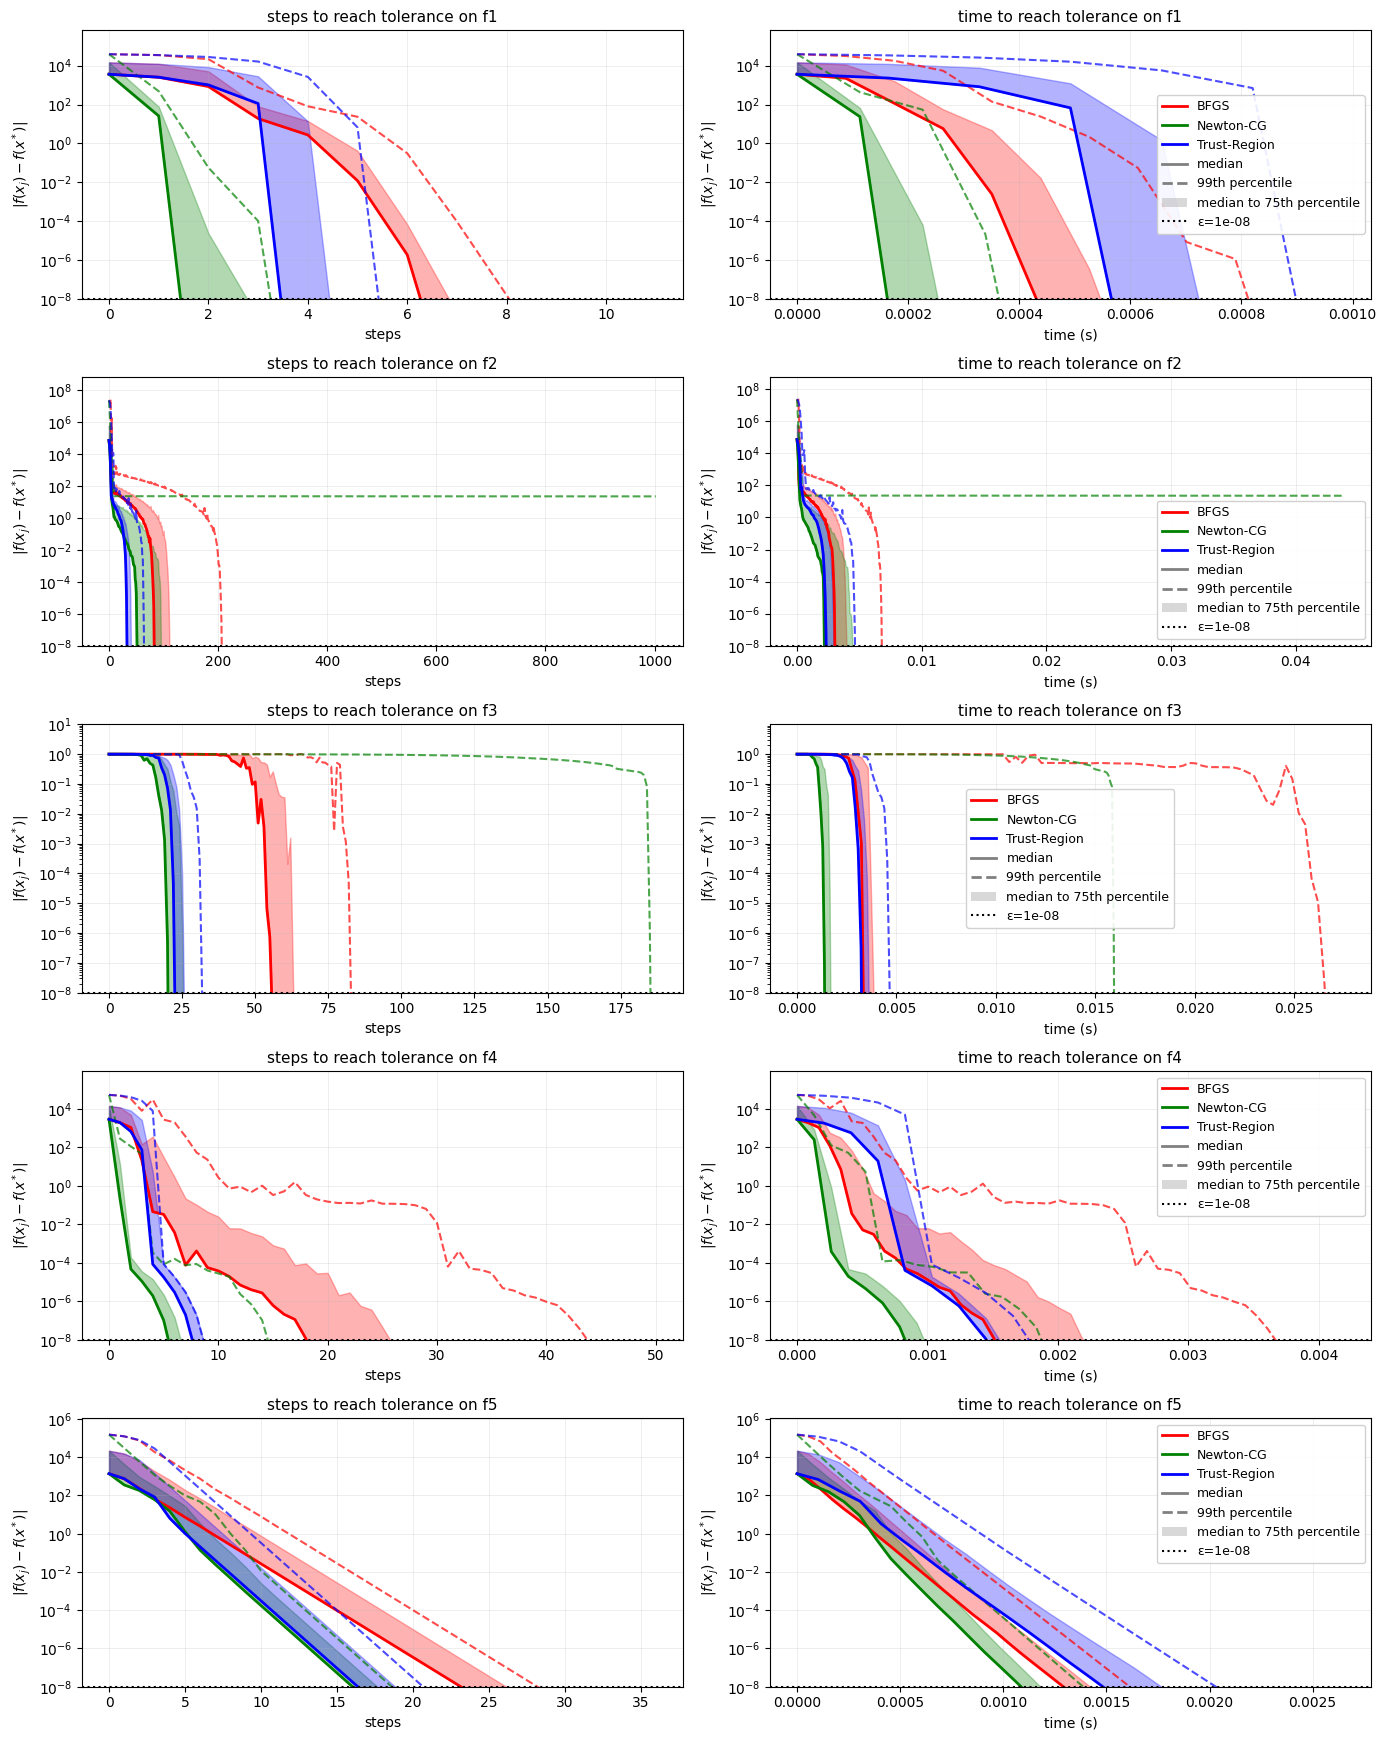

In [25]:
# Create convergence comparison plots
fig = plot_convergence_comparison(results, function_suite, epsilon=1e-8)
plt.show()

### Week 2

Comparing Steepest Descent vs BFGS on all functions...


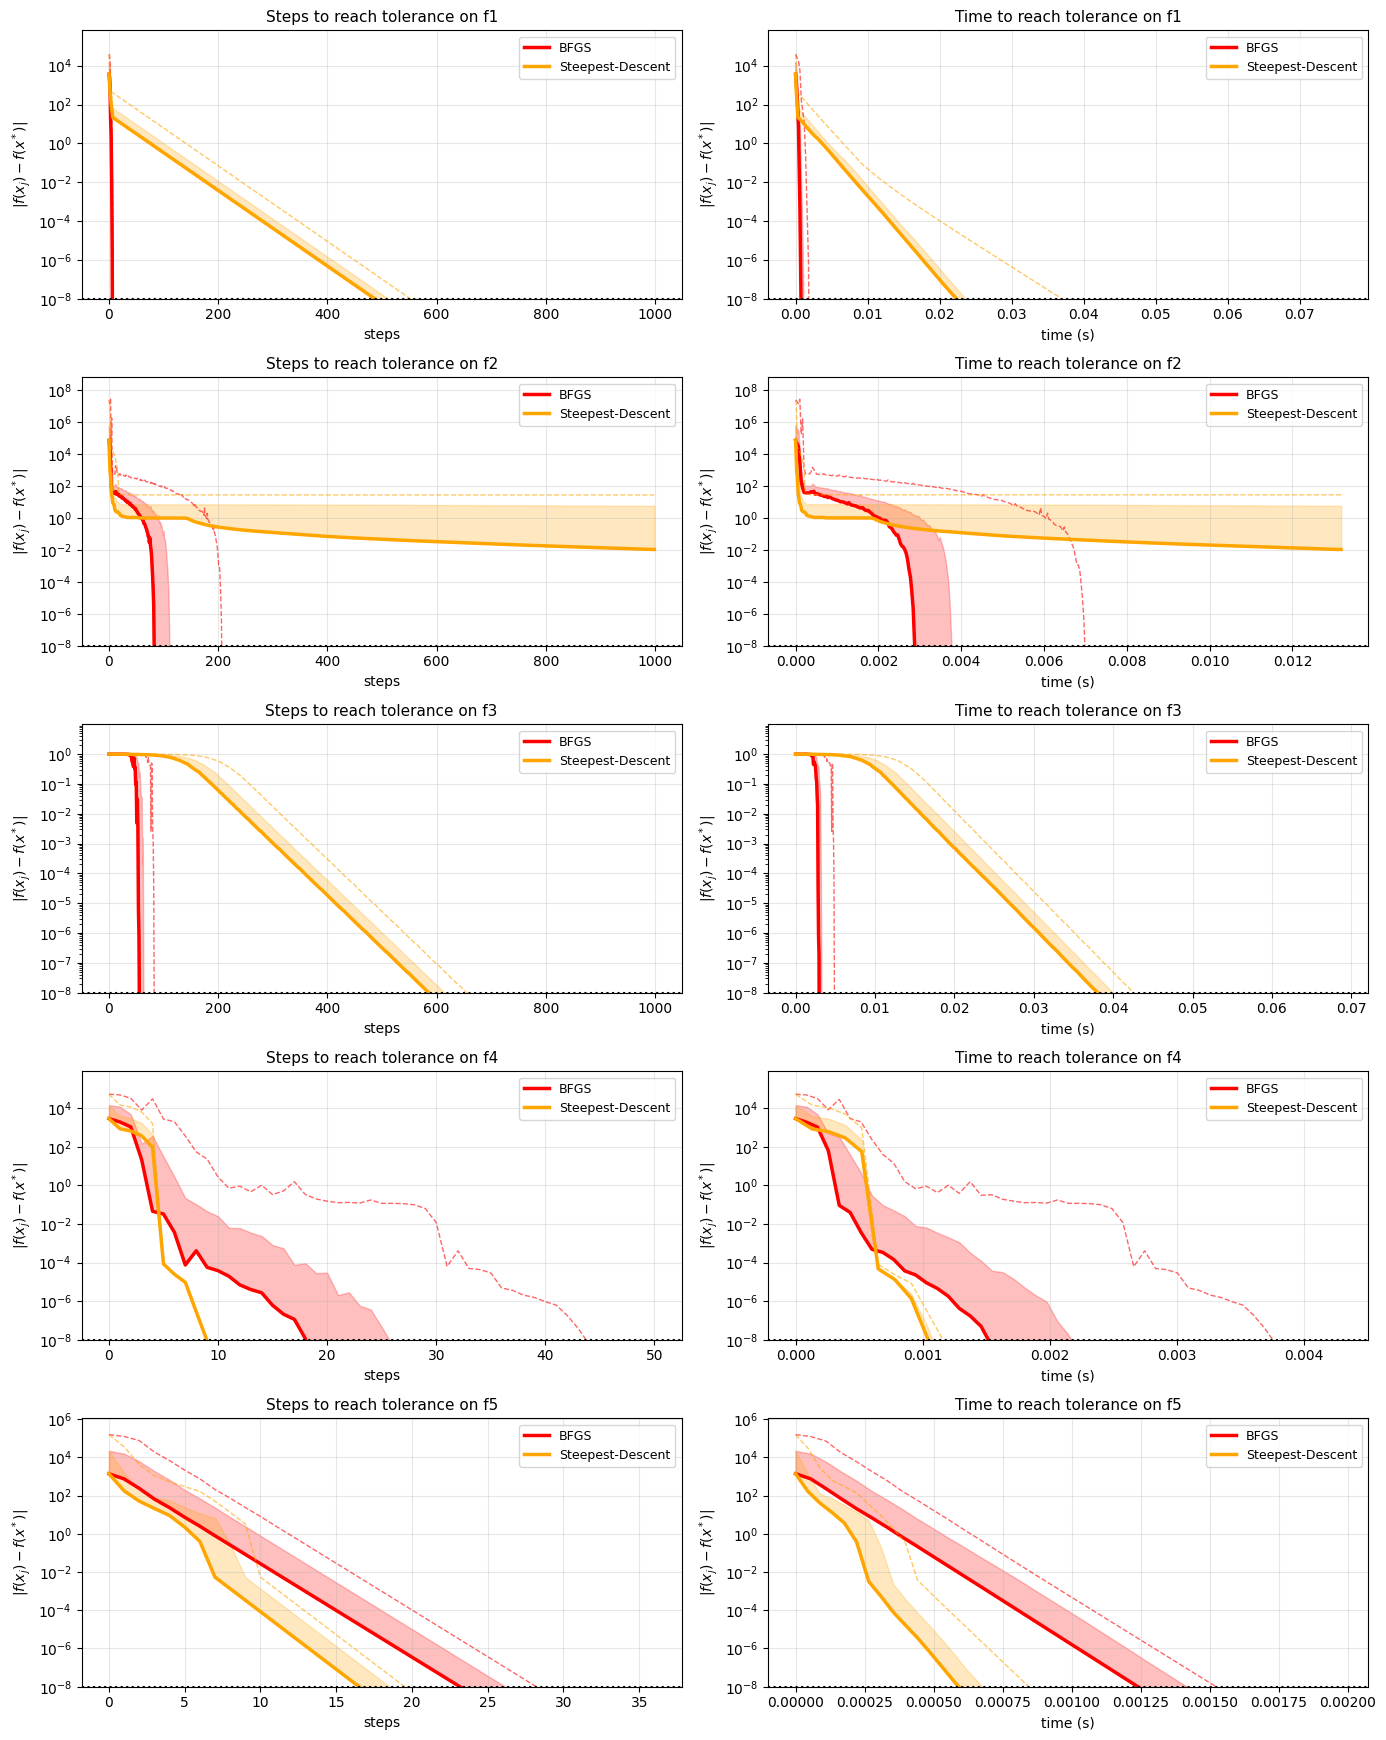


✓ Comparison plot complete for all functions!


In [26]:
# Compare Steepest Descent with BFGS on all functions
print("Comparing Steepest Descent vs BFGS on all functions...")

# Wrapper for steepest descent to match interface
def steepest_descent_wrapper(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    xs = []
    grad_norms = []
    
    i = 0
    b = 1
    x_current = x0.copy()
    
    def bt_LS(x, b, p_k):
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))
        
        if grad_norm < epsilon:
            break
        
        p_k = -grad
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    
    return np.array(xs), np.array(grad_norms)

# Run both optimizers on all functions
optimizers_compare = [
    ("BFGS", scipy_bfgs),
    ("Steepest-Descent", steepest_descent_wrapper)
]

function_suite_all = [
    ("f1", f1, df1, Hf1, 2),
    ("f2", f2, df2, Hf2, 2),
    ("f3", f3, df3, Hf3, 2),
    ("f4", f4, df4, Hf4, 2),
    ("f5", f5, df5, Hf5, 2)
]

results_compare = run_testing_protocol(function_suite_all, optimizers_compare, 
                                       n_initial_points=50, max_iter=1000, epsilon=1e-8)

# Plot comparison for all functions
n_funcs = len(function_suite_all)
fig, axes = plt.subplots(n_funcs, 2, figsize=(14, 3.5*n_funcs))

colors = {'BFGS': 'red', 'Steepest-Descent': 'orange'}
epsilon = 1e-8

for idx, (func_name, _, _, _, _) in enumerate(function_suite_all):
    ax_steps = axes[idx, 0]
    ax_time = axes[idx, 1]
    
    for opt_name in ['BFGS', 'Steepest-Descent']:
        run_results = results_compare[func_name][opt_name]
        if not run_results:
            continue
        
        stats = aggregate_run_statistics(run_results)
        color = colors[opt_name]
        
        # Plot steps
        ax_steps.semilogy(stats['steps'], stats['median_steps'], 
                         color=color, linewidth=2.5, label=opt_name)
        ax_steps.fill_between(stats['steps'], 
                             stats['median_steps'],
                             stats['p75_steps'],
                             color=color, alpha=0.25)
        ax_steps.semilogy(stats['steps'], stats['p99_steps'], 
                         color=color, linewidth=1, linestyle='--', alpha=0.6)
        
        # Plot time
        ax_time.semilogy(stats['time'], stats['median_time'], 
                        color=color, linewidth=2.5, label=opt_name)
        ax_time.fill_between(stats['time'], 
                            stats['median_time'],
                            stats['p75_time'],
                            color=color, alpha=0.25)
        ax_time.semilogy(stats['time'], stats['p99_time'], 
                        color=color, linewidth=1, linestyle='--', alpha=0.6)
    
    # Add epsilon line
    ax_steps.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5)
    ax_time.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5)
    
    # Set limits
    ax_steps.set_ylim(bottom=epsilon)
    ax_time.set_ylim(bottom=epsilon)
    
    # Format plots
    ax_steps.set_xlabel('steps', fontsize=10)
    ax_steps.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
    ax_steps.set_title(f'Steps to reach tolerance on {func_name}', fontsize=11)
    ax_steps.grid(True, alpha=0.3)
    ax_steps.legend(loc='best', fontsize=9)
    
    ax_time.set_xlabel('time (s)', fontsize=10)
    ax_time.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
    ax_time.set_title(f'Time to reach tolerance on {func_name}', fontsize=11)
    ax_time.grid(True, alpha=0.3)
    ax_time.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Comparison plot complete for all functions!")

In [ ]:
# NEW version with eigenvalue modification
def newton_backtracking_eigenvalue(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Newton's Method following lecture slides pseudocode exactly.
    Uses eigenvalue modification: H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
    
    This matches Algorithm 4 from the slides.
    """
    xs = []
    grad_norms = []
    
    i = 0
    b = 1
    x_current = x0.copy()
    
    def bt_LS(x, b, p_k):
        """Backtracking line search"""
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    
    def compute_newton_direction_eigenvalue(H, g):
        """
        Compute Newton direction following lecture slides.
        
        If H is positive definite: p = -H⁻¹g
        Else: Compute eigenvalues λᵢ and eigenvectors vᵢ
              H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
              p = -H_modified · g
        """
        # Check if positive definite via Cholesky
        try:
            L = np.linalg.cholesky(H)
            y = np.linalg.solve(L, -g)
            p = np.linalg.solve(L.T, y)
            return p
        except np.linalg.LinAlgError:
            # H is not positive definite - use eigenvalue modification
            eigenvalues, eigenvectors = np.linalg.eigh(H)
            
            # Reconstruct with absolute values: H = Σ (1/|λᵢ|) vᵢvᵢᵀ
            # This is equivalent to: H_modified = V · diag(1/|λ|) · Vᵀ
            abs_inv_eigenvalues = 1.0 / np.abs(eigenvalues)
            
            # Compute H_modified · g efficiently without forming full matrix
            # H_modified · g = V · diag(1/|λ|) · Vᵀ · g
            temp = eigenvectors.T @ g  # Vᵀ · g
            temp = abs_inv_eigenvalues * temp  # diag(1/|λ|) · (Vᵀ · g)
            p = -(eigenvectors @ temp)  # -V · result
            
            return p
    
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))
        
        if grad_norm < epsilon:
            break
        
        # Compute Hessian and get Newton direction
        hess = Hf(x_current)
        p_k = compute_newton_direction_eigenvalue(hess, grad)
        
        # Backtracking line search
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    
    return np.array(xs), np.array(grad_norms)

Comparing Newton's Method vs Steepest Descent vs BFGS on all functions...


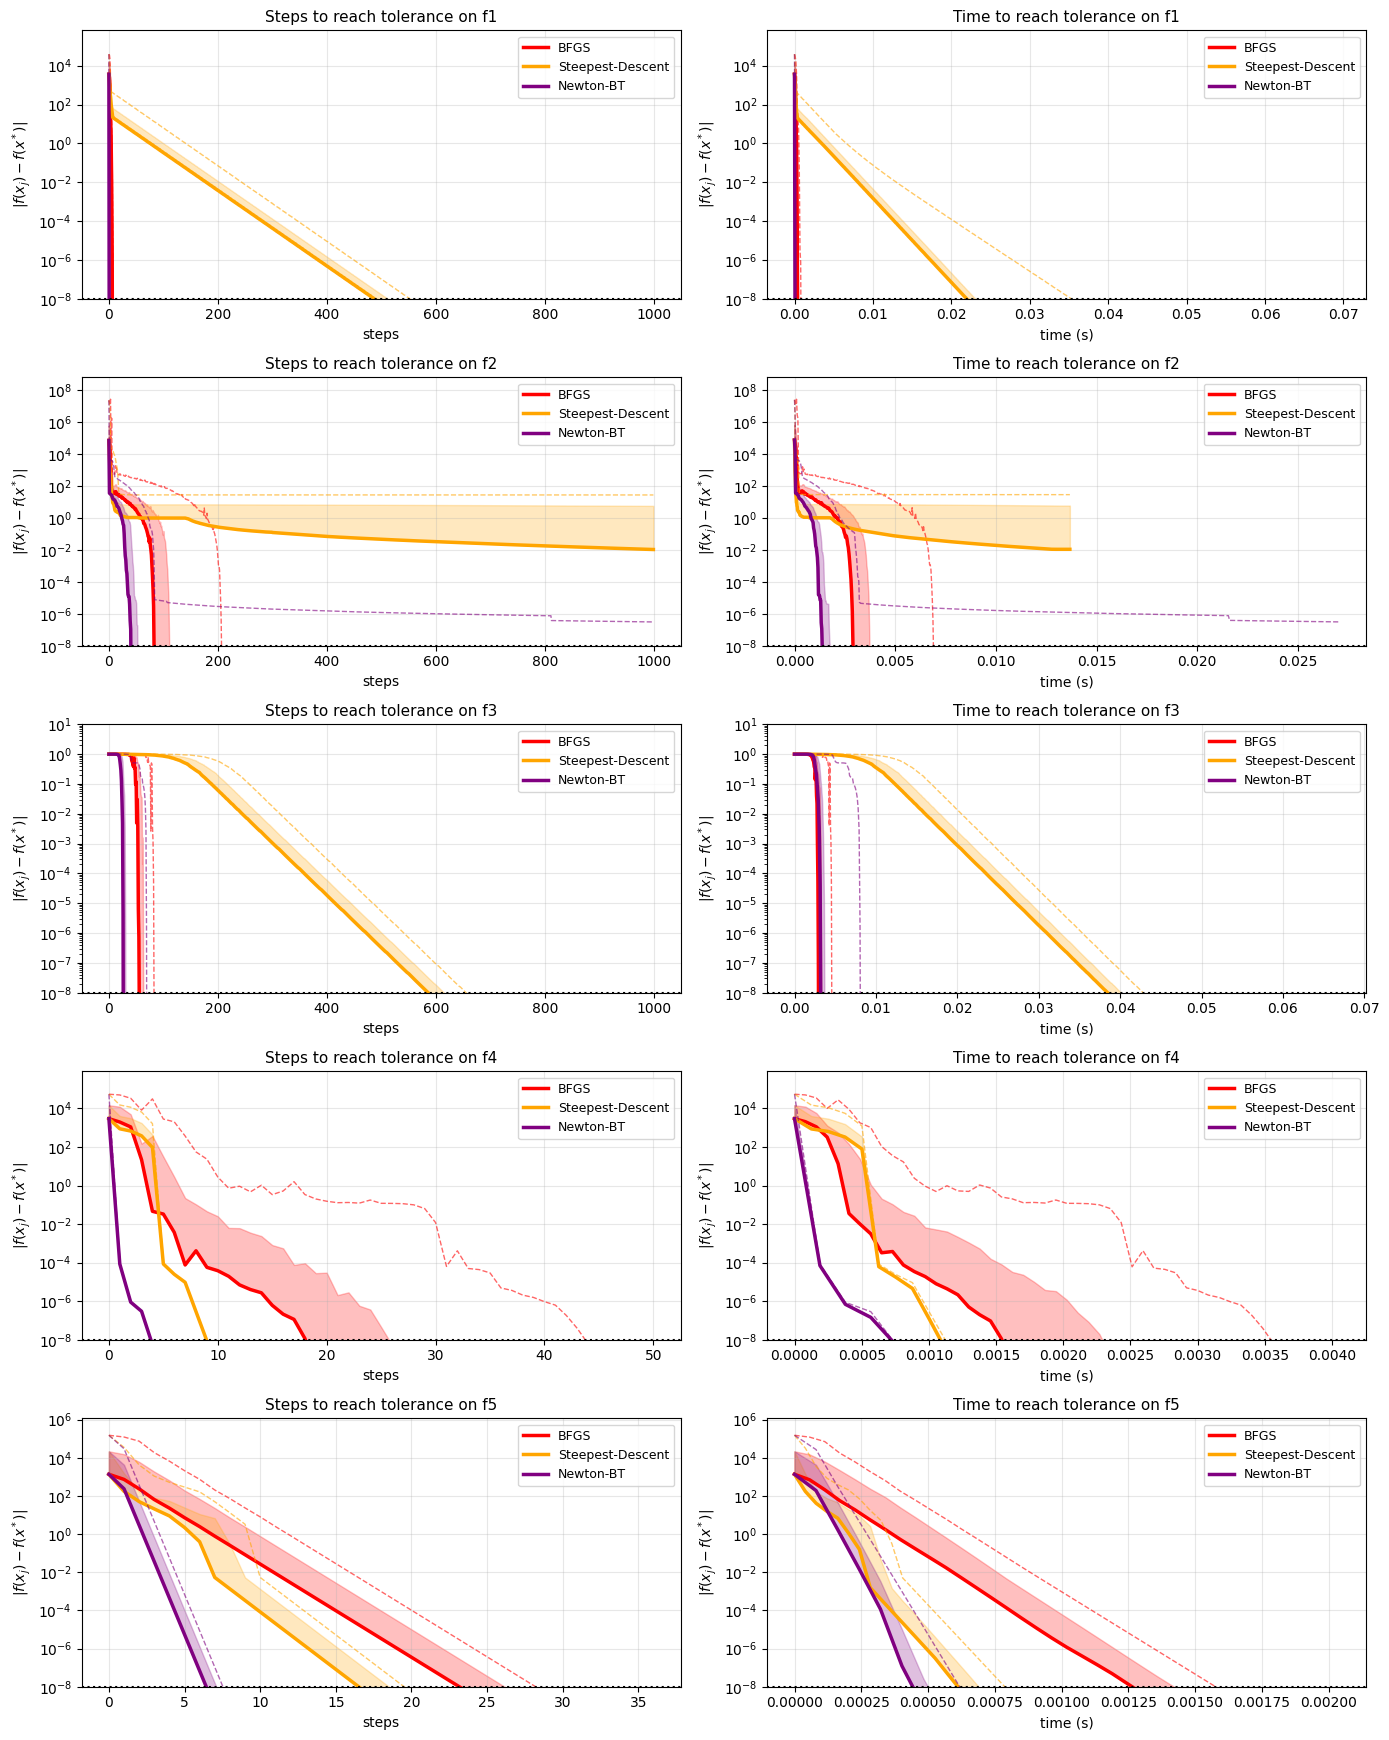


✓ Newton's Method comparison complete!


In [28]:
# Add Newton to your comparison
print("Comparing Newton's Method vs Steepest Descent vs BFGS on all functions...")

optimizers_newton = [
    ("BFGS", scipy_bfgs),
    ("Steepest-Descent", steepest_descent_wrapper),
    ("Newton-BT", newton_backtracking)
]

# Run the testing protocol with all three optimizers
results_newton = run_testing_protocol(function_suite_all, optimizers_newton, 
                                      n_initial_points=50, max_iter=1000, epsilon=1e-8)

# Plot comparison for all functions
n_funcs = len(function_suite_all)
fig, axes = plt.subplots(n_funcs, 2, figsize=(14, 3.5*n_funcs))

colors = {'BFGS': 'red', 'Steepest-Descent': 'orange', 'Newton-BT': 'purple'}
epsilon = 1e-8

for idx, (func_name, _, _, _, _) in enumerate(function_suite_all):
    ax_steps = axes[idx, 0]
    ax_time = axes[idx, 1]
    
    for opt_name in ['BFGS', 'Steepest-Descent', 'Newton-BT']:
        run_results = results_newton[func_name][opt_name]
        if not run_results:
            continue
        
        stats = aggregate_run_statistics(run_results)
        color = colors[opt_name]
        
        # Plot steps
        ax_steps.semilogy(stats['steps'], stats['median_steps'], 
                         color=color, linewidth=2.5, label=opt_name)
        ax_steps.fill_between(stats['steps'], 
                             stats['median_steps'],
                             stats['p75_steps'],
                             color=color, alpha=0.25)
        ax_steps.semilogy(stats['steps'], stats['p99_steps'], 
                         color=color, linewidth=1, linestyle='--', alpha=0.6)
        
        # Plot time
        ax_time.semilogy(stats['time'], stats['median_time'], 
                        color=color, linewidth=2.5, label=opt_name)
        ax_time.fill_between(stats['time'], 
                            stats['median_time'],
                            stats['p75_time'],
                            color=color, alpha=0.25)
        ax_time.semilogy(stats['time'], stats['p99_time'], 
                        color=color, linewidth=1, linestyle='--', alpha=0.6)
    
    # Add epsilon line
    ax_steps.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5)
    ax_time.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5)
    
    # Set limits
    ax_steps.set_ylim(bottom=epsilon)
    ax_time.set_ylim(bottom=epsilon)
    
    # Format plots
    ax_steps.set_xlabel('steps', fontsize=10)
    ax_steps.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
    ax_steps.set_title(f'Steps to reach tolerance on {func_name}', fontsize=11)
    ax_steps.grid(True, alpha=0.3)
    ax_steps.legend(loc='best', fontsize=9)
    
    ax_time.set_xlabel('time (s)', fontsize=10)
    ax_time.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
    ax_time.set_title(f'Time to reach tolerance on {func_name}', fontsize=11)
    ax_time.grid(True, alpha=0.3)
    ax_time.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Newton's Method comparison complete!")